In [62]:
import numpy as np
import subtractr
import subtractr.utils as utils
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import jit, vmap

from subtractr.low_rank import _svd_init
from jax.experimental import loops

from subtractr.low_rank import _nmu
import jax.numpy as jnp
from sklearn.isotonic import IsotonicRegression
from functools import partial

jax.config.update("jax_enable_x64", True)

s1 residual 8.226652603735417
Solutions are close? True


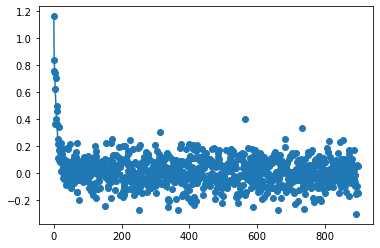

In [158]:
def _make_pava_pools(y, gamma=1.0):
  y = jnp.array(y)
  lg = jnp.log(gamma)
  T = len(y)

  v = jnp.zeros_like(y)
  w = jnp.zeros_like(y)
  l = jnp.zeros_like(y, dtype=jnp.int32)

  v = v.at[0].set(y[0])
  w = w.at[0].set(1)
  l = l.at[0].set(1)

  i = 0  # index of last pool

  def _outer_loop_fun(t, outer_state):
    (i, v, w, l) = outer_state
    i += 1

    v = v.at[i].set(y[t])
    w = w.at[i].set(1)
    l = l.at[i].set(1)

    (i, t, v, w, l) = jax.lax.while_loop(
      _check_inner_loop,
      _inner_loop_fun,
      (i, t, v, w, l)
    )
    return (i, v, w, l)

  def _check_inner_loop(state):
    (i, t, v, w, l) = state
    return jnp.all(jnp.array([i > 0,
      (v[i-1] / w[i-1] * jnp.exp(lg*l[i-1]) > (v[i] / w[i]))
    ]))
  
  def _inner_loop_fun(state):
    (i, t, v, w, l) = state
    i -= 1

    v = v.at[i].set(v[i] + v[i+1] * jnp.exp(lg*l[i]))
    w = w.at[i].set(w[i] + w[i+1] * jnp.exp(2*lg*l[i]))
    l = l.at[i].set(l[i] + l[i+1])
    
    l = l.at[i+1].set(0)
    w = w.at[i+1].set(0)
    v = v.at[i+1].set(0)
    return (i, t, v, w, l)

  outer_state = (i, v, w, l)
  state = jax.lax.fori_loop(1, T, _outer_loop_fun, outer_state)
  (i, v, w, l) = state
  return v, w, l

def _reconstruct_from_pools(y_orig, v, w, l, gamma):
  out = jnp.zeros_like(y_orig)
  lg = jnp.log(gamma)

  def _add_one_pool(i, state):
    t_curr, out = state
    value, weight, length = v[i], w[i], l[i]
    out = jax.lax.fori_loop(
      t_curr.astype(int), (t_curr + length).astype(int),
      lambda j, out: out.at[j].set(value / weight * jnp.exp(lg * (j - t_curr))),
      out)
    t_curr += length
    return (t_curr, out)

  state = (0, out)
  state = jax.lax.fori_loop(0, len(v), _add_one_pool, state)
  (t_curr, out) = state
  return out

@jit
def pava_decreasing(y, gamma=1.0):
  v, w, l = _make_pava_pools(-y, gamma=gamma)
  return -_reconstruct_from_pools(y, v, w, l, gamma)

def _reconstruct_from_blocks(v, w, l):
  out = np.zeros(np.sum(l))
  t_curr = 0
  for value, weight, length in zip(v, w, l):
    if length == 0:
      break
    out[t_curr:t_curr+length] = value / weight * np.exp(np.log(gamma)*(np.arange(length)))
    t_curr += length
  return out

np.random.seed(1)
gamma = 0.9
# a = np.array([10, 10, 12])
# a = np.random.rand(10)
N = 900
a = np.exp(np.log(0.9)*(np.arange(N))) + np.random.randn(N) * 0.1
# print('v', v)
# print('w', w)
# print('l', l)

s1 = pava_decreasing(a, gamma=gamma)
print('s1 residual', np.sum((s1 - a)**2))

# compare to cvxpy
import cvxpy
x = cvxpy.Variable(len(a))
objective = cvxpy.Minimize(cvxpy.sum_squares(x - a))
constraints = [x[i+1] <= gamma * x[i] for i in range(len(a)-1)]
prob = cvxpy.Problem(objective, constraints)
prob.solve()
s2 = x.value
print('Solutions are close?', np.allclose(s2, s1))

plt.plot(s1)
plt.scatter(np.arange(len(a)), a)
# plt.plot(_pava_naive(a, gamma=gamma), color='orange')
check_pava(s1, gamma=gamma)
# plt.plot(-v / w)

In [159]:


@partial(jax.jit, static_argnames=('stim_start', 'stim_end', 'rank'))
def estimate_photocurrents_nmu_extended_baseline(traces, 
    stim_start=100, stim_end=200, rank=1, gamma=0.99):
    """Estimate photocurrents using non-negative matrix underapproximation.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    stim_start : int
        Index of first timepoint of stimulus.
    stim_end : int
        Index of last timepoint of stimulus.
    rank : int
        Rank of the estimated matrix.

    Returns
    -------
    U : array-like
        Estimated U matrix. Shape is (n_traces, rank).
    V : array-like
        Estimated V matrix. Shape is (rank, n_timepoints).
    beta : array-like
        Estimated baseline term. Shape is (n_traces, 1).
    """
    # Create dummy initial factors
    # to use SVD initialization inside _rank_one_nmu
    U_init = jnp.zeros((traces.shape[0], rank)) * jnp.nan
    traces = jnp.maximum(0, traces)
    start_idx = 0
    V_init = jnp.zeros((rank, stim_end - start_idx)) * jnp.nan
    
    # Fit baseline along with first rank-one term
    U_stim, V_stim, beta = _nmu(traces[:, start_idx:stim_end], (U_init, V_init), 
        rank=rank, update_U=True, update_V=True, baseline=True, stim_start=stim_start)
    
    # Use beta as the weights in U to fit a rank-one term
    # to the entire trace, constraining V to be decreasing
    U_baseline_init = beta
    V_baseline_init = jnp.ones((1, traces.shape[1]))
    baseline_init_factors = (U_baseline_init, V_baseline_init)
    U_baseline, V_baseline, _ = _rank_one_nmu_decreasing(traces, baseline_init_factors, 
        update_U=False, update_V=True, gamma=gamma)
    traces = traces - U_baseline @ V_baseline

    # Fit the rest of V using NMU
    V_photo_init = jnp.linalg.lstsq(U_stim, traces[:, stim_start:])[0]
    _, V_photo, _ = _nmu(traces[:, stim_start:], rank=rank, init_factors=(U_stim, V_photo_init),
        update_U=False, update_V=True, baseline=False)

    # pad V with zeros to account for the time before stim_start
    V_photo = jnp.concatenate((jnp.zeros((rank, stim_start)), V_photo), axis=1)

    # Create full U and V adding the learned baseline term
    U_full = jnp.concatenate((U_stim, U_baseline), axis=1)
    V_full = jnp.concatenate((V_photo, V_baseline), axis=0)

    # zero out beta since we already have it in U
    beta = jnp.zeros_like(beta)

    return U_full, V_full, beta


def _rank_one_nmu_decreasing(traces, init_factors,
    update_U=True, update_V=True, 
    maxiter=5000, tol=1e-2, rho=1.0, gamma=1.0):
    """Non-negative matrix underapproximation with rank 1 using ADMM

    Init factors must be passed as a tuple of U and V matrices, due to the way JAX handles
    optional arguments. If init_factors_contains NaN, override with SVD initialization.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
    update_U : bool
        If True, update U.
    update_V : bool
        If True, update V.
    maxiter : int
        Maximum number of iterations.
    tol : float
        Tolerance for convergence.
    rho : float
        ADMM penalty parameter.
    init_factors : tuple of array-like
        Initial U and V matrices. Shape is (n_traces, rank) and (rank, n_timepoints).
        If None, initialize using SVD.

    Returns
    -------
    U : array-like
        U matrix. Shape is (n_traces, rank).
    V : array-like
        V matrix. Shape is (rank, n_timepoints).
    beta : array-like
        Baseline term. Shape is (n_traces, 1).
    max_violation : array-like
        Maximum violation of non-underapprox constraint at each iteration.
    """  
    U, V = init_factors
    U, V = jax.lax.cond(
        jnp.any(jnp.isnan(U @ V)),
        lambda _: _svd_init(traces),
        lambda _: init_factors,
        None
    )

    Gamma = jnp.zeros_like(traces)
    lam = jnp.zeros_like(V)
    q = V
    R = jnp.maximum(0, traces - U @ V)
    U_old = U.copy() + 10 * tol
    V_old = V.copy() + 10 * tol
    k = 0
    max_violation = jnp.zeros(maxiter) * jnp.nan
    val = (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation) 


    def _convergence_tol_check(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        return jnp.any(jnp.array([
            (jnp.linalg.norm(U - U_old) / jnp.linalg.norm(U_old) > tol),
            (jnp.linalg.norm(V - V_old) / jnp.linalg.norm(V_old) > tol),
            (jnp.linalg.norm(V - q) > tol),
            jnp.min(traces - U @ V) < -tol,
        ]))

    def _not_converged(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        return jax.lax.cond(
            k < maxiter,
            lambda _: _convergence_tol_check(val),
            lambda _: False,
            None
        )

    def _update(val):
        U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation = val
        U_old = U.copy()
        V_old = V.copy()
        M = traces - R + Gamma / rho
        resid = traces - U @ V
        if update_U:
            U = M @ V.T
            U = jnp.maximum(0, U)
            U = jax.lax.cond(
                jnp.all(U <= 1e-10),
                lambda _: U * 0.0,
                lambda _: U / jnp.linalg.norm(U),
                None,
            )
        if update_V:

            # update V
            V = (U.T @ (Gamma + rho * (traces - U @ V)) + lam + rho * q) / (rho * (U.T @ U + 1))
            V = jnp.maximum(0, V)
                
            # update auxiliary variable q
            q_tilde = pava_decreasing(jnp.squeeze(V - lam / rho), gamma=gamma)
            q = q_tilde[None, :]

            # update lagrange multiplier
            lam = lam + rho * (q - V)

        R = 1 / (1 + rho) * (rho * resid + Gamma)
        R = jnp.maximum(0, R)
        Gamma = Gamma + rho * (resid - R)
        max_violation = max_violation.at[k].set(jnp.min(traces - U @ V))
        k += 1
        return (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation)
    val = jax.lax.while_loop(
        _not_converged,
        _update,
        val,
    )
    (U, V, q, lam, U_old, V_old, R, Gamma, k, max_violation) = val

    return U, V, max_violation

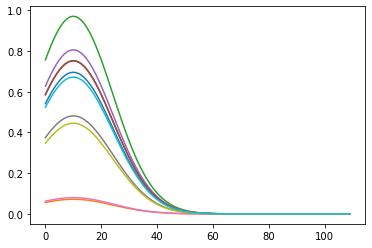

In [160]:
t = np.arange(-0.1, 1.0, 0.01)
v_true = np.exp(-(t)**2 / 0.2**2)[None, :]
u_true = np.random.rand(10, 1)
X = u_true @ v_true
# X += np.random.randn(*X.shape) * 0.001
plt.plot(X.T)


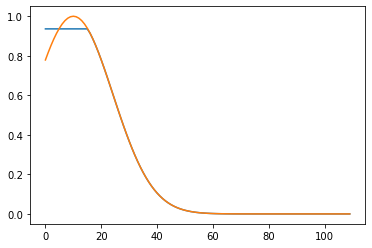

In [161]:
plt.plot(pava_decreasing(np.squeeze(v_true), gamma=1.0))
plt.plot(v_true.T)

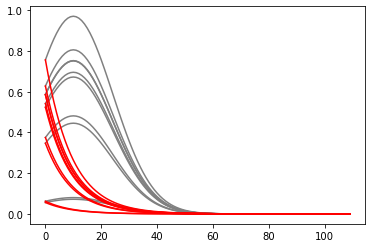

In [164]:
U_init, V_init = np.zeros_like(u_true) * np.nan, np.zeros_like(v_true) * np.nan 
U, V, max_violation = _rank_one_nmu_decreasing(X, (U_init, V_init), maxiter=2000, tol=1e-3, gamma=0.9)
est = U @ V
plt.plot(X.T, color='grey')
plt.plot(est.T, color='red')

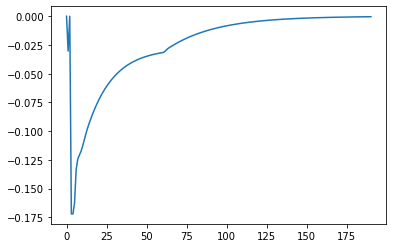

In [190]:
plt.plot(max_violation)

In [165]:
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/targeted_opsin_positive/preprocessed/cell7_emx_map_221214_cmFormat.mat')

In [166]:
idxs = np.argsort(pscs[:, 100:160].sum(axis=1))[::-1]
pscs = pscs[idxs, :]

In [178]:
U, V, beta = estimate_photocurrents_nmu_extended_baseline(pscs[0:100], rank=1, gamma=0.999)

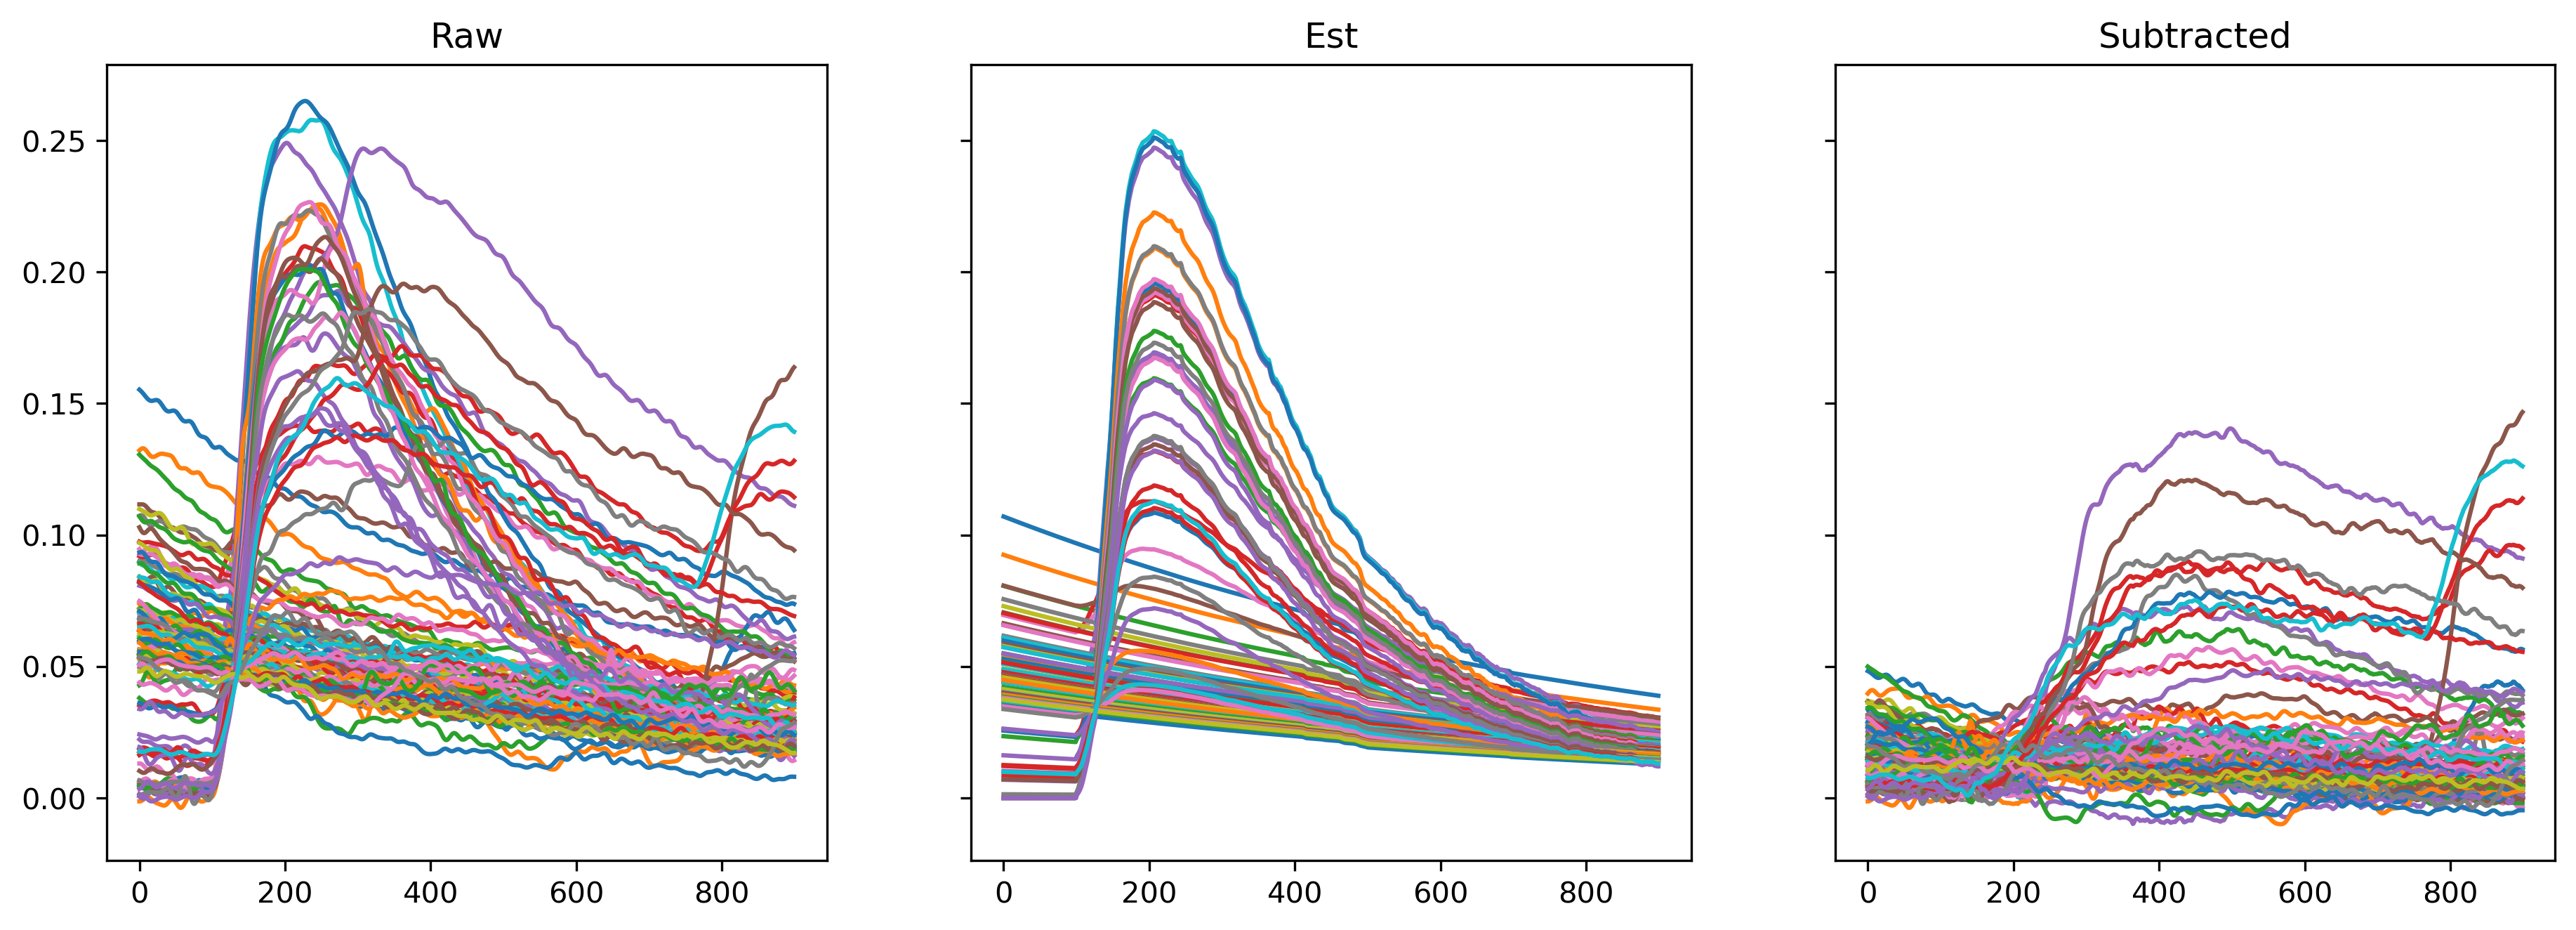

In [179]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300, facecolor='white', sharey=True)
axs[0].plot(pscs[0:100].T)
axs[0].set_title('Raw')

axs[1].plot((U @ V + beta).T)
axs[1].set_title('Est')

axs[2].plot((pscs[0:100] - U @ V - beta).T)
axs[2].set_title('Subtracted')
plt.show()

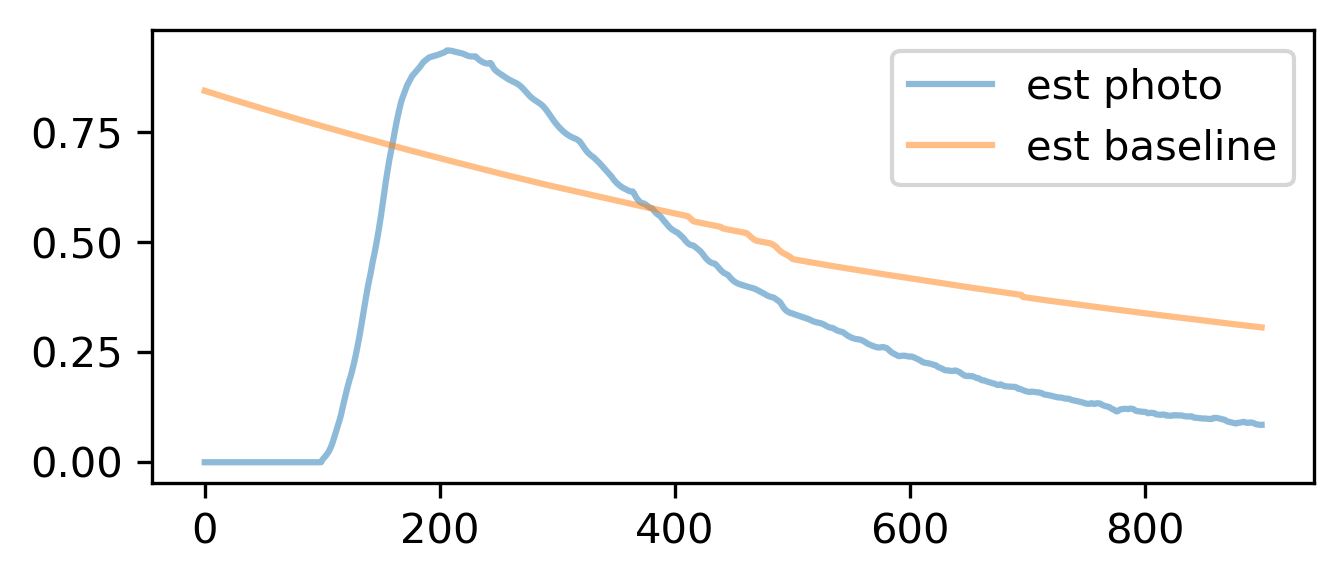

In [180]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(V[0], label='est photo', alpha=0.5)
plt.plot(V[2], label='est baseline', alpha=0.5)
plt.legend()

In [181]:
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/targeted_opsin_positive/preprocessed/cell8_vc_emx_map_221219_cmFormat.mat')
idxs = np.argsort(pscs[:, 100:160].sum(axis=1))[::-1]
pscs = pscs[idxs, :]

In [186]:
batch_start_idx = 200
batch_end_idx = 300
batch = pscs[batch_start_idx:batch_end_idx, :]
U, V, beta = estimate_photocurrents_nmu_extended_baseline(batch, rank=1, gamma=0.999)

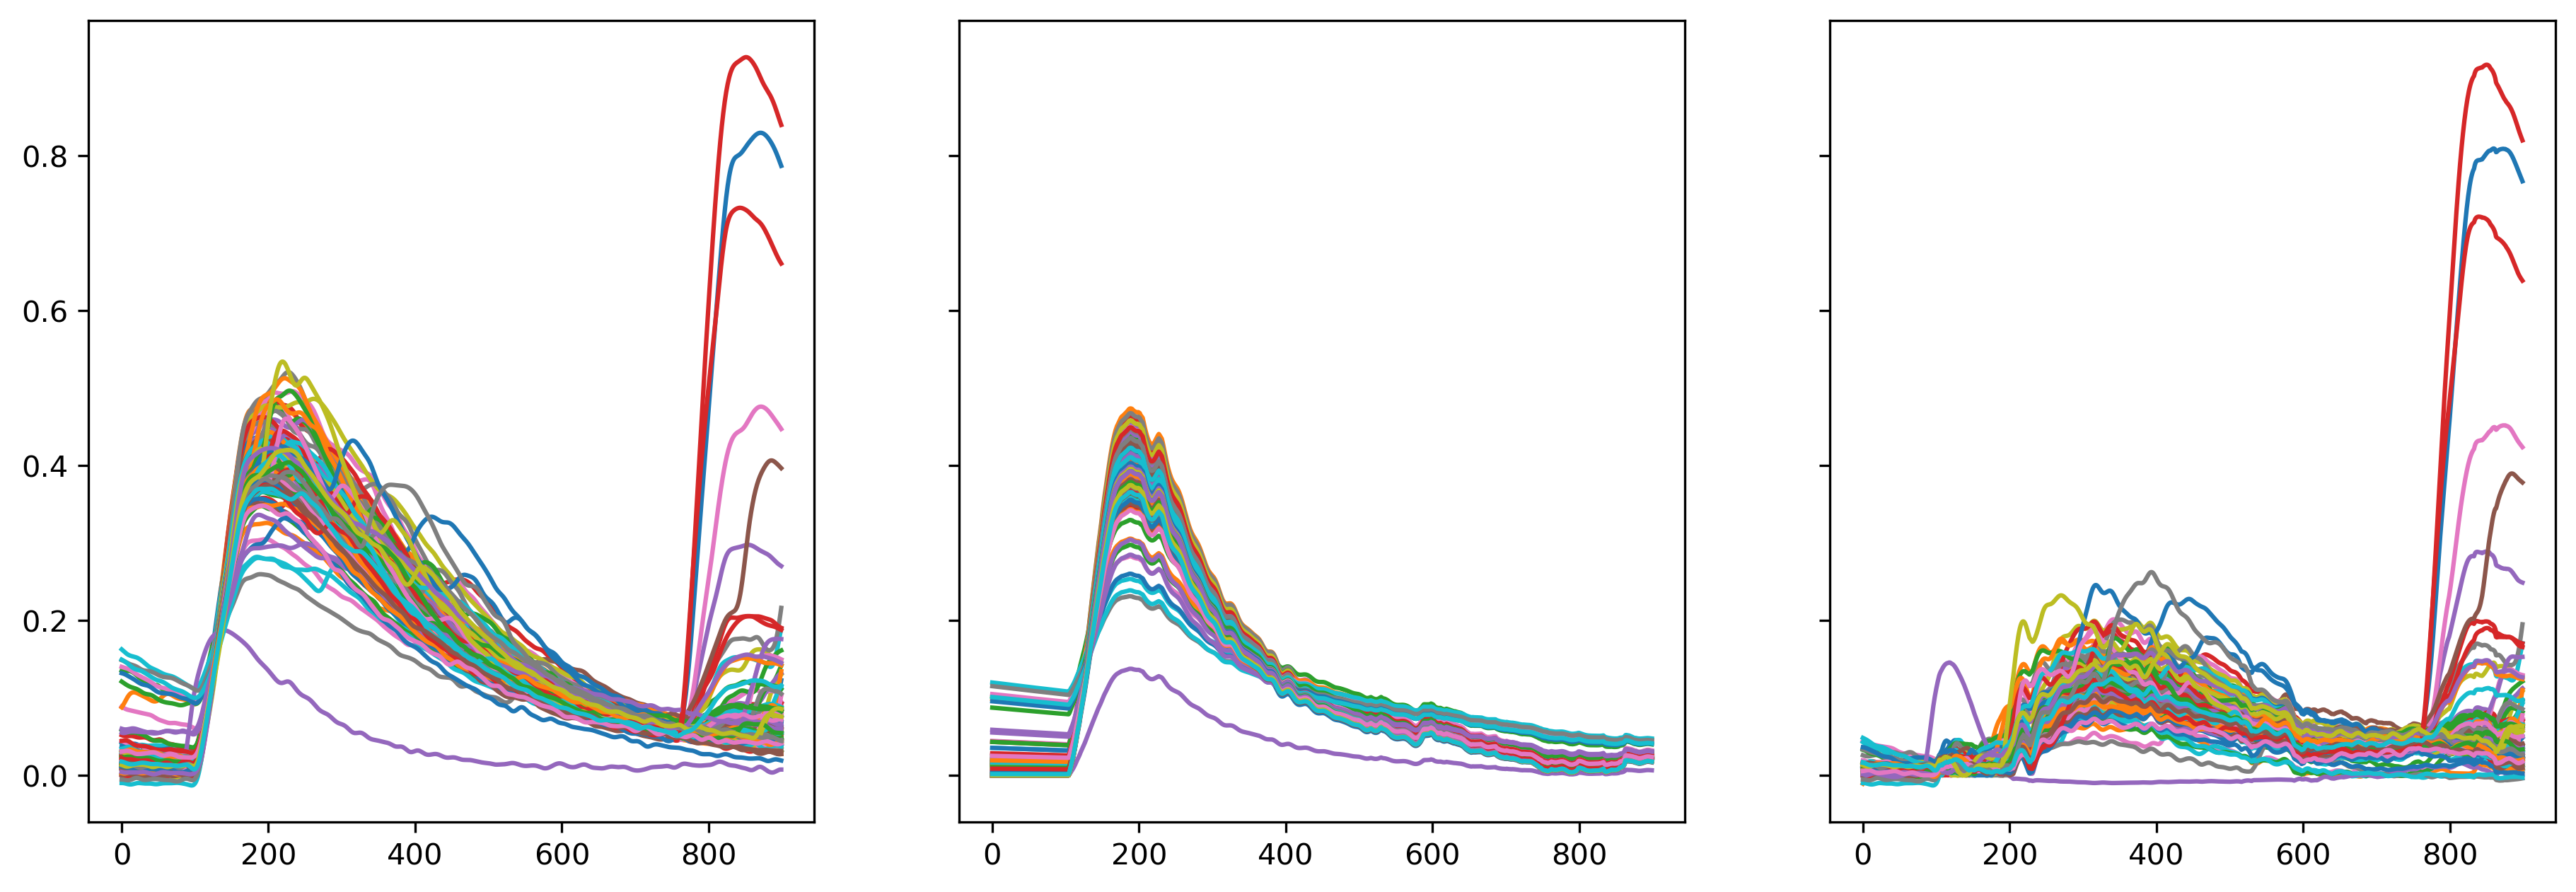

In [187]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300, facecolor='white', sharey=True)
axs[0].plot(batch.T)
axs[1].plot((U @ V + beta).T)
axs[2].plot((batch - U @ V - beta).T)
plt.show()

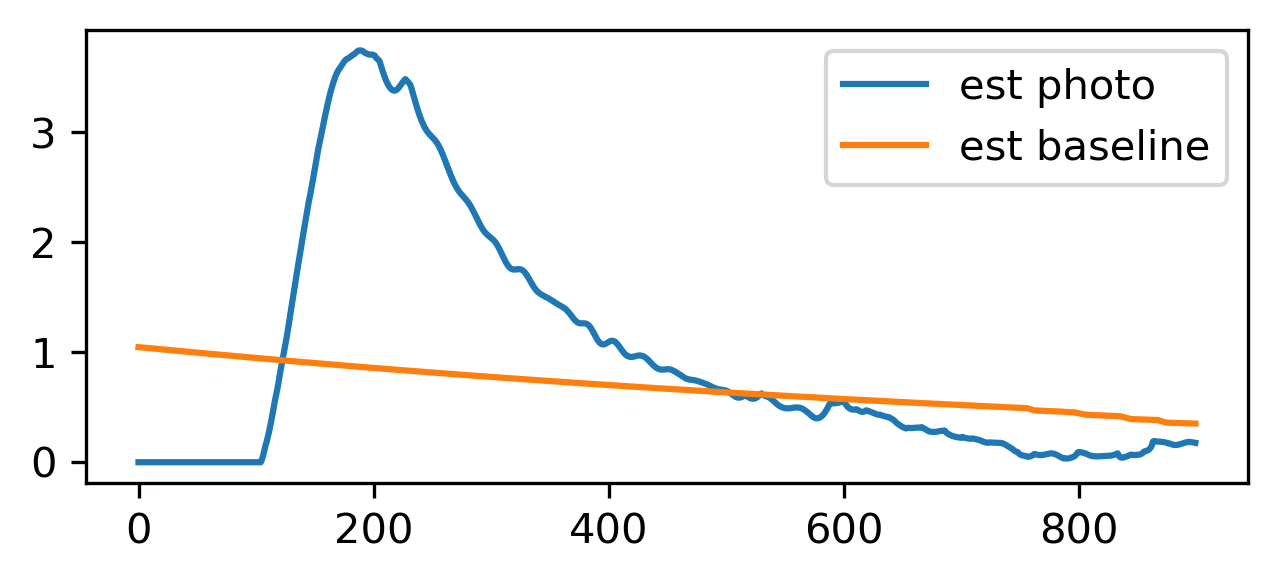

In [189]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(V[0], label='est photo')
plt.plot(V[1], label='est baseline')
plt.legend()